In [49]:
from pathlib import Path

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
if 'tommylees' in Path('.').absolute().parts:
    data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data')
out_dir = data_dir / 'analysis' / 'region_analysis'


# Read the data

In [6]:
ds = xr.open_dataset(data_dir / 'interim' / 'VCI_preprocessed' / 'data_kenya.nc')
ds

<xarray.Dataset>
Dimensions:  (lat: 311, lon: 244, time: 454)
Coordinates:
  * time     (time) datetime64[ns] 1981-08-31 1981-09-30 ... 2019-05-31
  * lon      (lon) float64 33.5 33.54 33.57 33.61 ... 42.14 42.18 42.21 42.25
  * lat      (lat) float64 -5.17 -5.134 -5.098 -5.062 ... 5.921 5.957 5.993
Data variables:
    VCI      (time, lat, lon) float32 ...

In [10]:
df = ds.VCI.mean(dim=['lat', 'lon']).to_dataframe()
df = df.reset_index().rename(columns={'time': 'ds', 'VCI': 'y'})
df.head()

,ds,y
0,1981-08-31,63.998329
1,1981-09-30,66.038170
2,1981-10-31,61.201485
3,1981-11-30,43.486206
4,1981-12-31,28.517225


# Fit Prophet Time Series Model

In [57]:
mcmc = True

m = Prophet(
      growth='linear',                # linear or logistic growth?
      changepoints=None,              # specify your own changepoints?
      n_changepoints=20,              # how many changepoints in history
      changepoint_range=0.8,          # how much of history to use for changepoints
      yearly_seasonality='auto',      # no. of fourier terms for yr seasonality
      weekly_seasonality=False,       #       """            for wk seasonality
      daily_seasonality=False,        #       """            for dy seasonality
      holidays=None,                  # holiday dates to estimate effect
      seasonality_mode='additive',    # additive or multiplicative?
      seasonality_prior_scale=0.01,    # smaller prior = more 'restrictive' in terms of seasonality - how variable the seasonality
      changepoint_prior_scale=0.01,   # how many changepoints to fit / how flexible the changepoint selection (want some regularisation)
      mcmc_samples=1000 if mcmc else 0,              # if 0 then use MAP optimisation, else use MCMC
      interval_width=0.80,            # width of the uncertainty intervals (80% of data inside the uncertainty intervals)
      uncertainty_samples=500         # no. of simulated draws used to estimate uncertainty samples
    )
m.fit(df)
print("*** Model Fitted! ***")

*** Model Fitted! ***


In [58]:
# creates 365 periods into the future
# future = m.make_future_dataframe(periods=365)

# create future df manually
future_times = pd.Series(pd.date_range(start=df.ds.max(), periods=20, freq='M')[1:])

future = pd.concat([df.ds, future_times]).reset_index().drop(columns='index').rename(columns={0: 'ds'})
future.tail()

,ds
468,2020-08-31
469,2020-09-30
470,2020-10-31
471,2020-11-30
472,2020-12-31


In [59]:
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1981-08-31,39.579635,26.492183,58.532378,37.890887,41.231692,2.889892,0.841091,4.875046,2.889892,0.841091,4.875046,0.0,0.0,0.0,42.469527
1,1981-09-30,39.591370,25.800181,58.725122,37.913998,41.236055,2.785602,0.759092,4.871845,2.785602,0.759092,4.871845,0.0,0.0,0.0,42.376972
2,1981-10-31,39.603496,24.906076,56.807019,37.932147,41.240486,0.951411,-1.133668,3.084147,0.951411,-1.133668,3.084147,0.0,0.0,0.0,40.554906
3,1981-11-30,39.615230,23.218495,55.633783,37.954907,41.244699,0.617085,-1.509007,2.771830,0.617085,-1.509007,2.771830,0.0,0.0,0.0,40.232315
4,1981-12-31,39.627356,23.823757,54.984624,37.976369,41.240855,-0.320546,-2.390012,1.715466,-0.320546,-2.390012,1.715466,0.0,0.0,0.0,39.306810


# Explore Model predictions

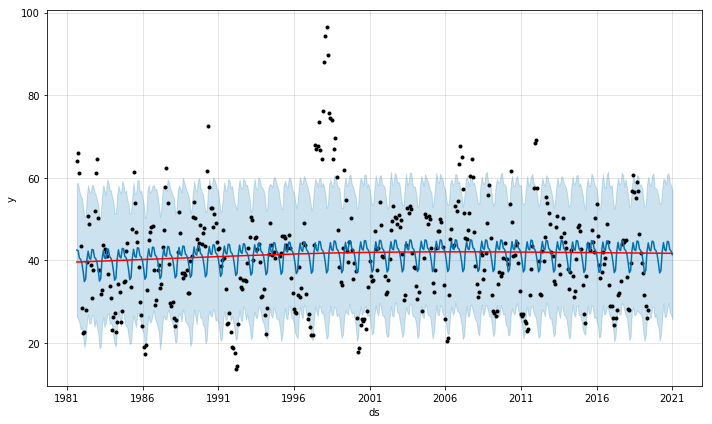

In [60]:
# make default plots (components & fit vs. obs)
fig1 = m.plot(forecast)
ax = plt.gca()
add_changepoints_to_plot(ax, m, forecast);
fig1 = plt.gcf()

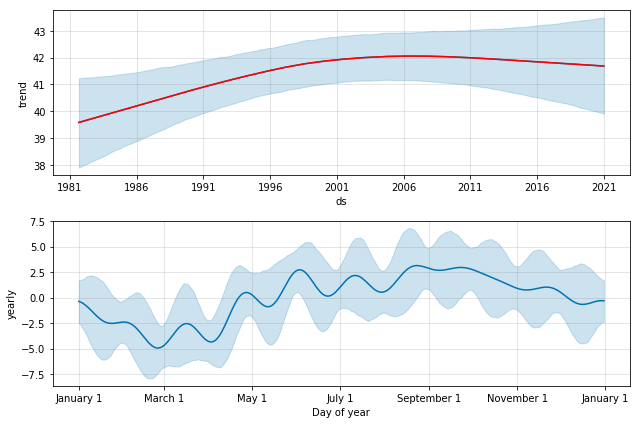

In [61]:
# make component plots BUT add the changepoints
fig2 = m.plot_components(forecast)
fig = plt.gcf()
axs = fig.get_axes()
ax = axs[0]
add_changepoints_to_plot(ax, m, forecast);
fig2 = plt.gcf()